# **Import Packages and Libraries**

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [13]:
train_logs = pd.read_csv('/content/train_logs.csv')
train_scores = pd.read_csv('/content/train_scores.csv')

<Axes: >

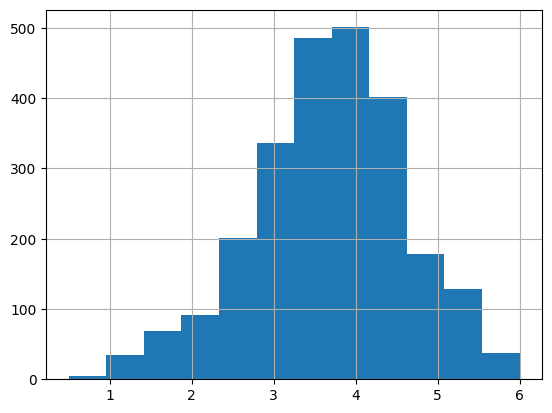

In [14]:
train_scores['score'].hist(bins=12)

In [15]:
train_scores.head(1000)['score'].value_counts()

4.0    201
3.5    189
4.5    173
3.0    141
2.5     75
5.0     75
5.5     48
2.0     36
1.5     29
6.0     15
1.0     14
0.5      4
Name: score, dtype: int64

In [16]:
df_train = train_logs

# **Data Preprocessing**

In [17]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    # Total/ Mean
    total_duration = df.groupby('id')['action_time'].sum()
    total_events = df.groupby('id').size()
    final_word_count = df.groupby('id')['word_count'].last()
    mean_action_time = df.groupby('id')['action_time'].mean()
    total_activity_counts = df['activity'].value_counts()

    # Compute activity counts only for the relevant activities
    activity_counts = df[df['activity'].isin(['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste'])].pivot_table(index='id', columns='activity', aggfunc='size', fill_value=0)

    # Combine into a single DataFrame
    processed_df = pd.concat([total_duration, total_events, activity_counts, mean_action_time, final_word_count], axis=1)
    processed_df.columns = ['total_duration', 'total_events'] + activity_counts.columns.tolist() + ['mean_action_time', 'final_word_count']

    return processed_df

In [18]:
processed_train_df = preprocess(df_train).merge(train_scores, on="id", suffixes=(None, None))

In [19]:
processed_train_df

,id,total_duration,total_events,Input,Nonproduction,Paste,Remove/Cut,Replace,mean_action_time,final_word_count,score
0,001519c8,297243,2557,2010,120,0,417,7,116.246774,255,3.5
1,0022f953,275391,2454,1938,254,1,260,1,112.221271,320,3.5
2,0042269b,421201,4136,3515,175,0,439,7,101.837766,404,6.0
3,0059420b,189596,1556,1304,99,1,151,1,121.848329,206,2.0
4,0075873a,313702,2531,1942,72,0,517,0,123.943896,252,4.0
...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,499670,4739,3588,189,0,960,2,105.437856,273,3.5
2467,ffbef7e5,214221,2604,2395,148,0,60,1,82.266129,438,4.0
2468,ffccd6fd,231580,3063,2849,126,0,88,0,75.605615,201,1.5
2469,ffec5b38,289439,3242,2895,71,0,276,0,89.277915,413,5.0


In [90]:
cols = ['total_duration', 'total_events',
       'Input', 'Nonproduction',
       'Paste', 'Remove/Cut',
       'Replace', 'mean_action_time',
       'final_word_count',]

Plots for total_duration


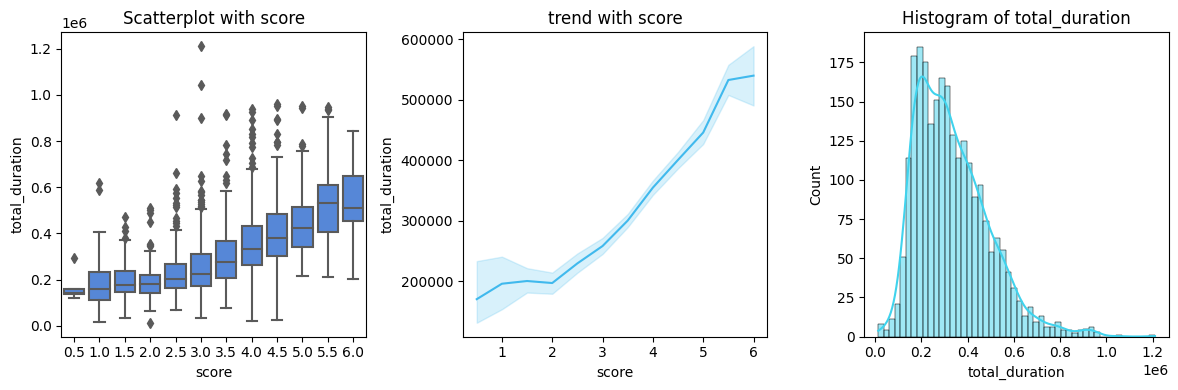

Plots for total_events


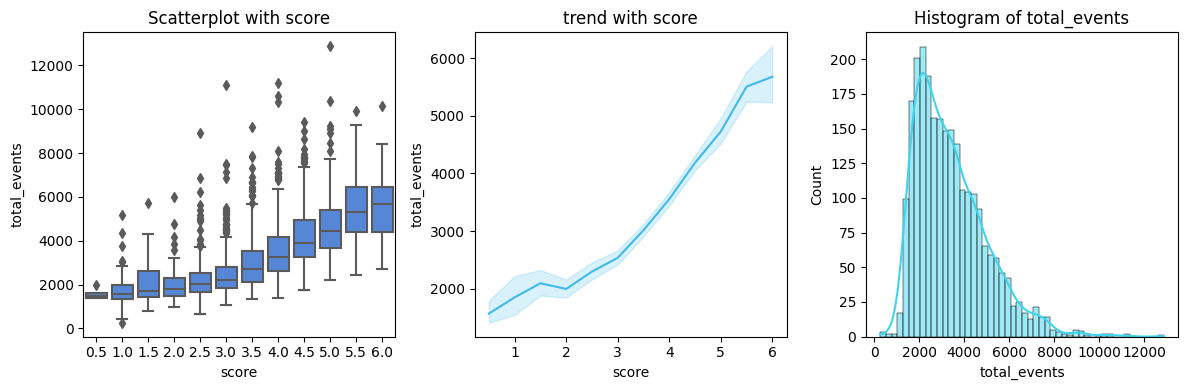

Plots for Input


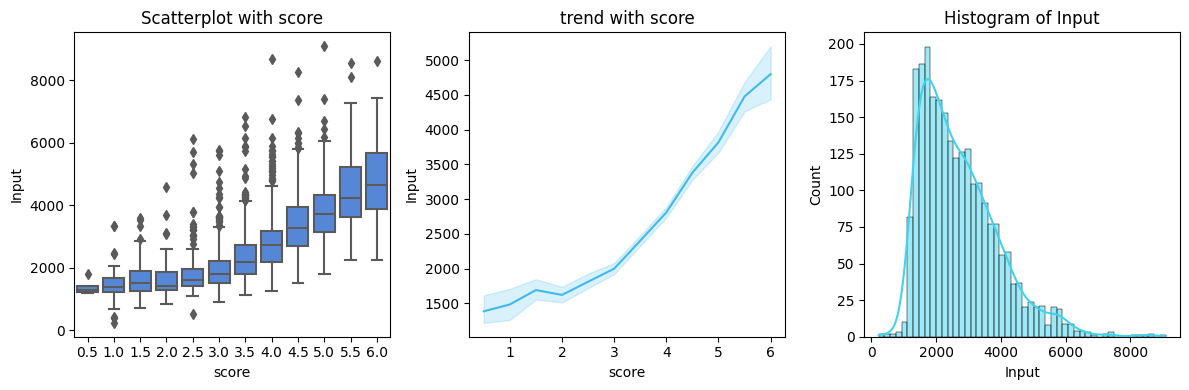

Plots for Nonproduction


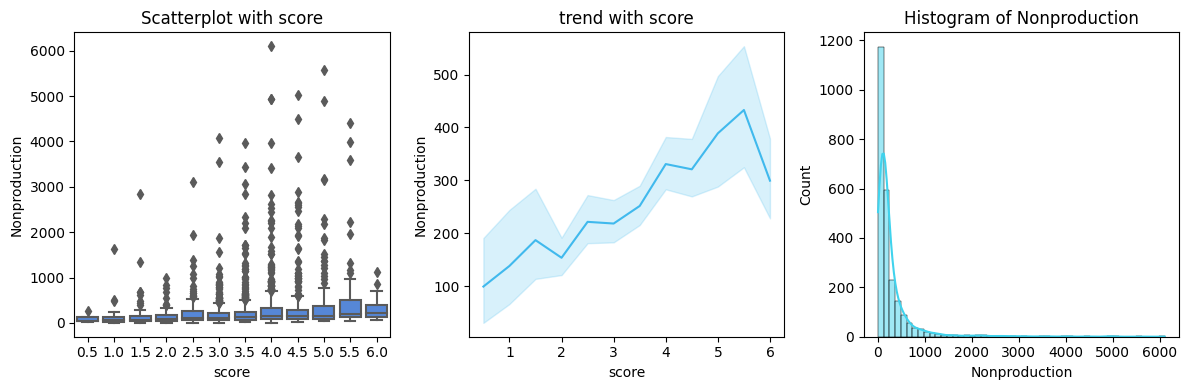

Plots for Paste


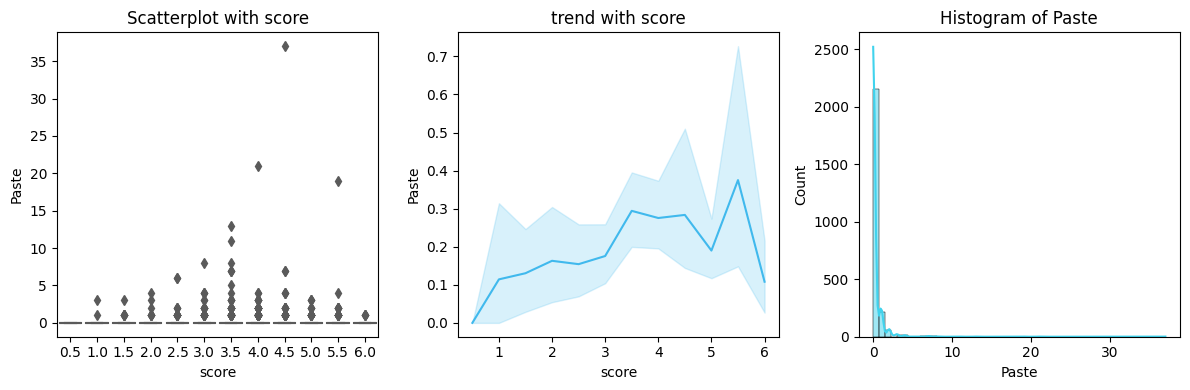

Plots for Remove/Cut


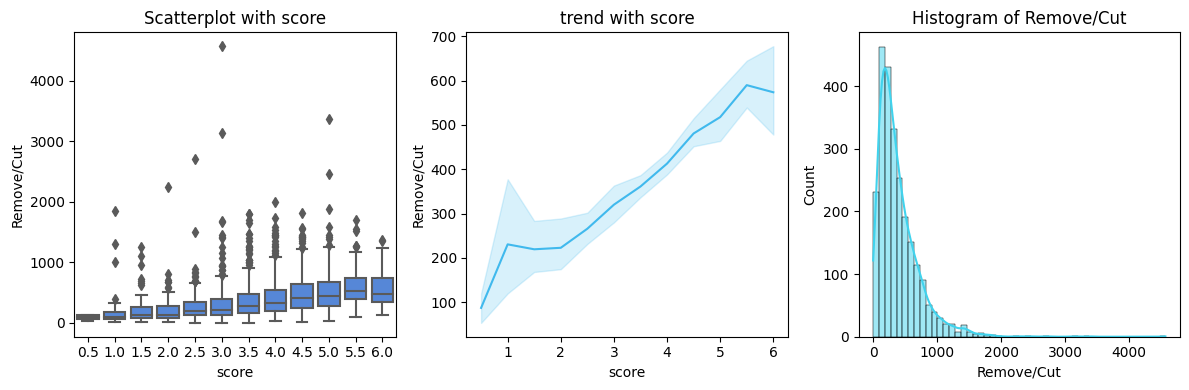

Plots for Replace


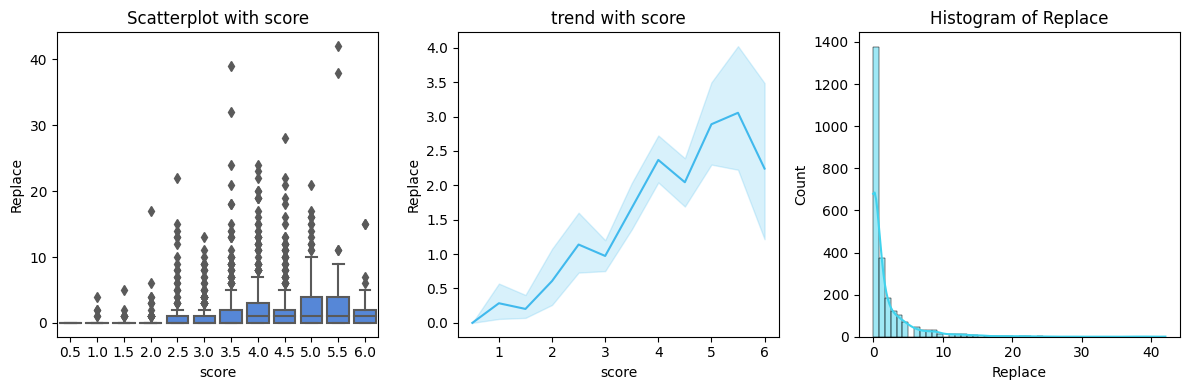

Plots for mean_action_time


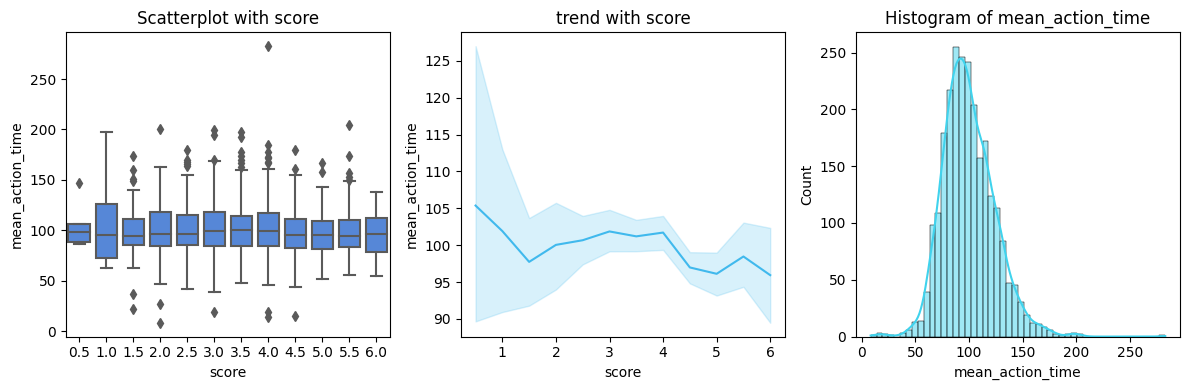

Plots for final_word_count


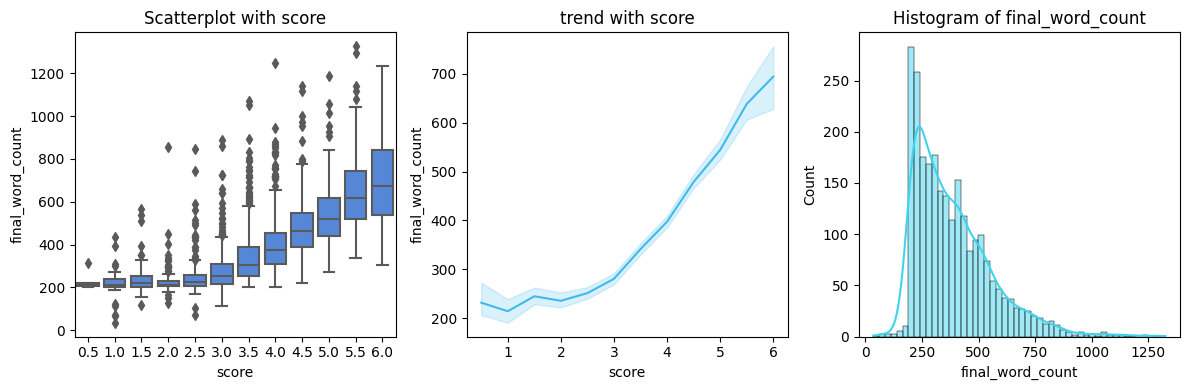

In [91]:
for col in cols:
    print(f'Plots for {col}')
    plt.figure(figsize=(12, 4))

    plt.subplot(1,3, 1)
    sns.boxplot(y=processed_train_df[col], x=processed_train_df['score'], color='#4082ed')
    plt.title("Scatterplot with score")

    plt.subplot(1, 3, 2)
    sns.lineplot(y=processed_train_df[col], x=processed_train_df['score'], color='#40b9ed')
    plt.title("trend with score")

    plt.subplot(1, 3, 3)
    sns.histplot(x=processed_train_df[col], bins=50, kde=True, color='#40d3ed')
    plt.title(f"Histogram of {col}")

    plt.tight_layout()
    plt.show()

In [45]:
# Drop id and split X and y
modeling_df = processed_train_df.drop(columns=['id'])
tX, tY = modeling_df.drop(columns=['score']), modeling_df['score']
training_columns = tX.columns

In [46]:
# Standard Scaler
scaler = StandardScaler()
tX_scaled = scaler.fit_transform(tX)

In [47]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(tX_scaled, tY, test_size=0.2, random_state=42)

In [48]:
X_train[0]

array([ 0.10134414, -0.44713748, -0.65234454, -0.34929211, -0.20151349,
        0.75826854, -0.49607963,  1.23332735, -0.8798958 ])

# **Modeling**

In [49]:
# random forest
clf = RandomForestRegressor(n_estimators=50)
clf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50)

In [50]:
y_pred = clf.predict(X_test)

In [51]:
# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.6478419497988626


In [52]:
# Calculate RMSE
mae = mean_absolute_error(y_test, y_pred)
# rmae = np.sqrt(mae)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.5022828282828282


In [68]:
# Create a random forest regressor
rf = RandomForestRegressor()

In [69]:
# Create a SelectFromModel object and specify the random forest regressor as the estimator
selector = SelectFromModel(estimator=rf, max_features=5)

In [70]:
# Create a pipeline
pipeline = Pipeline([
    ('selector', selector),
    ('random_forest_regressor', RandomForestRegressor())
])

In [78]:
# Define the grid of hyperparameters to tune
param_grid = {
    'random_forest_regressor__n_estimators': [100, 200, 300],
    'random_forest_regressor__max_depth': [3, 5, 7]
}

In [79]:
# Create a GridSearchCV object and specify the pipeline as the estimator
gscv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=8)

In [80]:
# Fit the GridSearchCV object to the training data
gscv.fit(X_train, y_train)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(),
                                                        max_features=5)),
                                       ('random_forest_regressor',
                                        RandomForestRegressor())]),
             param_grid={'random_forest_regressor__max_depth': [3, 5, 7],
                         'random_forest_regressor__n_estimators': [100, 200,
                                                                   300]})

In [81]:
# Select the best model from the GridSearchCV object
best_model = gscv.best_estimator_

In [82]:
# Evaluate the best model on the test data
y_pred = best_model.predict(X_test).clip(0.5, 6)

In [83]:
# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.6298936693739415


In [84]:
# Calculate RMSE
mae = mean_absolute_error(y_test, y_pred)
# rmae = np.sqrt(mae)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.488684755199634


# **Visualisation**

In [63]:
residuals = y_test - y_pred

In [64]:
residuals

1058   -0.242223
2178   -0.113336
1708    0.148066
1550    0.372673
353     0.175658
          ...   
2460    0.108455
1041   -0.428745
1936   -0.092404
168    -0.589831
961     0.155711
Name: score, Length: 495, dtype: float64

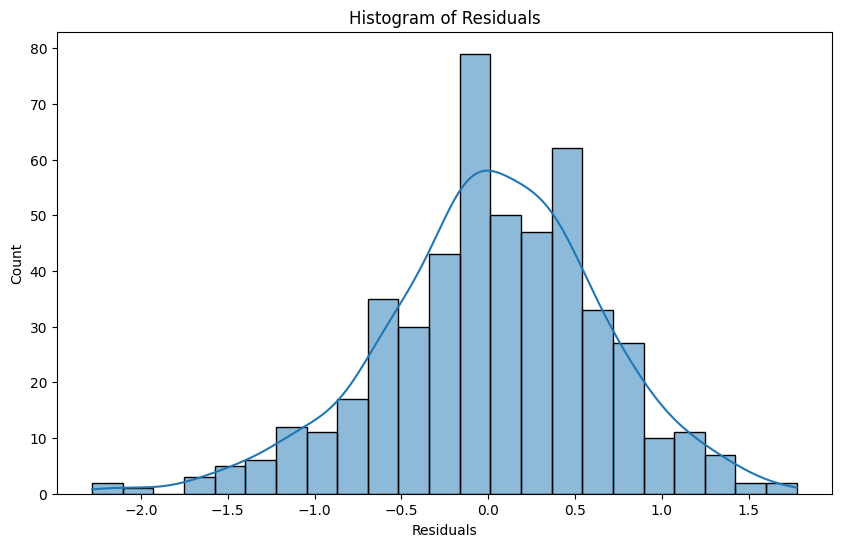

In [65]:
# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()

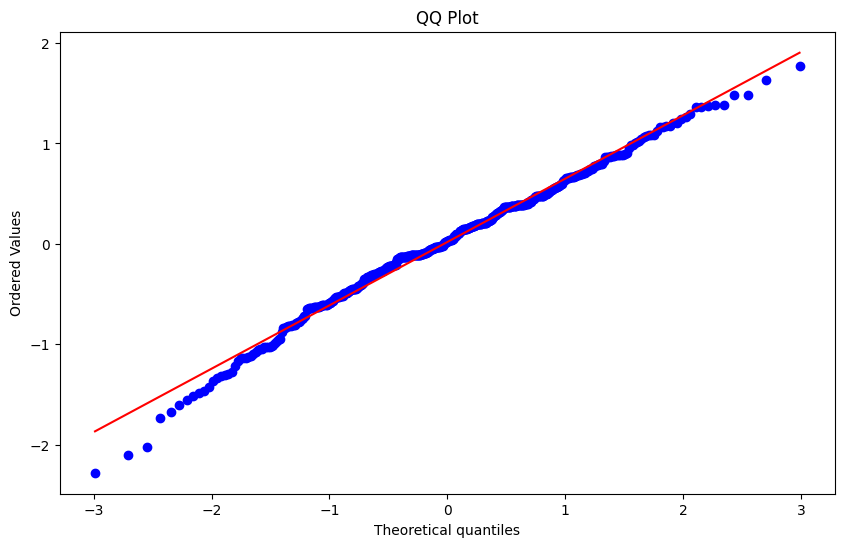

In [66]:
# QQ Plot
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot')
plt.show()